In [ ]:
import torch
import os
import sys
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random
from torch.optim import LBFGS, Adam
from pathlib import Path
from tqdm import tqdm
import wandb

# make sure that util is correctly accessed from parent directory
ppp_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if ppp_dir not in sys.path:
    sys.path.insert(0, ppp_dir)

from util import *
from model_parametrized.pinn_ff import FLS_params

In [2]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the CUDA version
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

CUDA available: True
CUDA version: 11.8
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce GTX 1650 Ti


In [3]:
# set seeds and configure cuda device
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

In [4]:
class ODEData(Dataset):
    def __init__(self, t_range, rho_values, t_points, constant_x, device='cuda:0'):
        """
        Initialize the dataset for a logistic growth ODE with a constant spatial coordinate.

        Args:
            t_range (list): Time domain [t_min, t_max].
            rho_values (list): List of reaction coefficients (ρ values).
            t_points (int): Number of time points.
            constant_x (float): The constant spatial coordinate (e.g., a representative location).
            device (str): Device to store the tensors ('cpu' or 'cuda:0').
        """
        self.device = device
        self.t_range = t_range
        self.rho_values = rho_values
        self.t_points = t_points
        self.constant_x = constant_x

        # Prepare data for each rho value.
        self.data = {}
        for rho in rho_values:
            # Generate residual points (time samples with constant x)
            res, ic = self._generate_data()
            res_tensor = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(self.device)
            ic_tensor = torch.tensor(ic, dtype=torch.float32, requires_grad=True).to(self.device)
            
            # Precompute analytical solution at the initial condition (t = t_range[0])
            u_ic = self.analytical_solution(
                torch.tensor([[constant_x]], dtype=torch.float32, requires_grad=True).to(self.device),
                torch.tensor([[t_range[0]]], dtype=torch.float32, requires_grad=True).to(self.device),
                rho
            )
            
            self.data[rho] = {
                'res': res_tensor,   # (x, t) pairs over the time domain (x is constant)
                'ic': ic_tensor,     # Initial condition point (t = t_range[0])
                'u_ic': u_ic         # Analytical solution at t = t_range[0]
            }

    def _generate_data(self):
        """
        Generate residual points (for the interior of the time domain) and the initial condition.
        
        Returns:
            res (np.ndarray): Array of shape (t_points, 2) where each row is [constant_x, t].
            ic (np.ndarray): Array of shape (1, 2) corresponding to the initial condition at t = t_range[0].
        """
        # Create time samples
        t = np.linspace(self.t_range[0], self.t_range[1], self.t_points)
        # For each t, x is always the constant value provided.
        x = self.constant_x * np.ones_like(t)
        # Stack x and t to create our (x,t) pairs.
        res = np.stack([x, t], axis=-1)  # Shape: (t_points, 2)
        # The initial condition is simply the first row.
        ic = res[0:1, :]
        return res, ic

    def analytical_solution(self, x, t, rho):
        """
        Compute the analytical solution for the logistic growth ODE.
        Here we use the same functional form as before:
        
        u(t) = h(x) * exp(ρ t) / (h(x) * exp(ρ t) + 1 - h(x)),  with
        h(x) = exp( - (x - π)² / [2*(π/4)²] ).
        
        Note: Since x is constant, h(x) is also constant.

        Args:
            x (torch.Tensor): The spatial input (constant value).
            t (torch.Tensor): Time input.
            rho (float): Reaction coefficient.
            
        Returns:
            torch.Tensor: The analytical solution.
        """
        pi = torch.tensor(np.pi, dtype=torch.float32, device=self.device)
        h = torch.exp(- (x - pi)**2 / (2 * (pi / 4)**2))
        return h * torch.exp(rho * t) / (h * torch.exp(rho * t) + 1 - h)

    def get_interior_points(self, rho):
        """
        Retrieve the interior (residual) points for a given rho.
        
        Returns:
            x (torch.Tensor): Spatial component (constant).
            t (torch.Tensor): Temporal component.
            rho_tensor (torch.Tensor): Tensor filled with the rho value.
        """
        res = self.data[rho]['res']
        x = res[:, 0:1]
        t = res[:, 1:2]
        rho_tensor = torch.full_like(x, rho)
        return x, t, rho_tensor

    def get_initial_condition(self, rho):
        """
        Retrieve the initial condition point and its analytical solution.
        
        Returns:
            x_ic, t_ic (torch.Tensor): The initial (x, t) point.
            rho_tensor (torch.Tensor): Tensor filled with the rho value.
            u_ic (torch.Tensor): The precomputed analytical solution at t = t_range[0].
        """
        ic = self.data[rho]['ic']
        x_ic = ic[:, 0:1]
        t_ic = ic[:, 1:2]
        rho_tensor = torch.full_like(x_ic, rho)
        u_ic = self.data[rho]['u_ic']
        return x_ic, t_ic, rho_tensor, u_ic

    def get_test_points(self, rho):
        """
        For this simple ODE experiment, the test points are the same as the interior points.
        
        Returns:
            x, t, rho tensor.
        """
        return self.get_interior_points(rho)


In [5]:
### setting configuration parameters and logging via wandb
total_i = 500
model_name = "fls_extended" 
in_dim = 3 
hidden_dim = 256 #64 #512 
out_dim=1
num_layer= 4 #2#4
bias_fill = 0.01

config_dict = {
    "total_i": total_i,
    "dataset": "1d-logistic-ode",
    "model": model_name,
    "in_dim": in_dim,
    "hidden_dim": hidden_dim, 
    "out_dim": out_dim, 
    "num_layer": num_layer,
    "init_weights": "xavier uniform", 
    "bias_fill": bias_fill,
    "optimizer": "adam", 
    "learning_rate": 0.001,
    "batch_size": 128
}

""" run = wandb. init(
    project="pinnsformer",
    config=config_dict,
    settings=wandb.Settings(silent=True)
) """

' run = wandb. init(\n    project="pinnsformer",\n    config=config_dict,\n    settings=wandb.Settings(silent=True)\n) '

In [6]:
# Train PINNs 
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(config_dict["bias_fill"])
        
model = FLS_params(in_dim=config_dict["in_dim"], hidden_dim=config_dict["hidden_dim"], out_dim=config_dict["out_dim"], num_layer=config_dict["num_layer"]).to(device)

model.apply(init_weights)

#model.apply(init_weights)
if config_dict["optimizer"] == "LBFGS":
    optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
elif config_dict["optimizer"] == "adam":
    optim = Adam(model.parameters(), lr=config_dict["learning_rate"])

print(model)
print(get_n_params(model))

C:\Users\prdie\AppData\Local\Temp\ipykernel_33204\66948627.py:4: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


FLS_params(
  (linear): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): SinAct()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)
132865


In [7]:
# Define rho values
rho_values = [0.5, 0.7, 0.8, 1.0] #-> error: 0.05
#rho_values = [0.5, 4, 5, 10.0] #-> error: 2,5
total_i = config_dict["total_i"]

# Create the dataset using the ODEData class.
# Note: We now provide t_range, t_points, a constant x value (e.g., 1.0), and rho_values.
dataset = ODEData(t_range=[0, 1], rho_values=rho_values, t_points=101, constant_x=1.0, device='cuda:0')

# %% Combined Training Loop for Multiple ρ Values

# Assume dataset.t_points is defined (e.g., 101)
t_points = dataset.t_points

loss_track = {}  # we'll store per-iteration per-ρ losses in a dict

In [8]:
if config_dict["optimizer"] == "LBFGS":

    for i in tqdm(range(total_i)):
        def closure():
            all_x_res, all_t_res, all_rho_res = [], [], []
            all_x_ic, all_t_ic, all_rho_ic, all_u_ic = [], [], [], []
            
            # Loop over each ρ value and accumulate data
            for rho in rho_values:
                # Get interior points for the current ρ
                x_res, t_res, rho_res = dataset.get_interior_points(rho)
                # Force gradients for residual points
                x_res = x_res.clone().detach().requires_grad_(True)
                t_res = t_res.clone().detach().requires_grad_(True)
                rho_res = rho_res.clone().detach().requires_grad_(True)
                
                all_x_res.append(x_res)
                all_t_res.append(t_res)
                all_rho_res.append(rho_res)
                
                # Get initial condition for the current ρ
                x_ic, t_ic, rho_ic, u_ic = dataset.get_initial_condition(rho)
                all_x_ic.append(x_ic)
                all_t_ic.append(t_ic)
                all_rho_ic.append(rho_ic)
                all_u_ic.append(u_ic)
            
            # Concatenate data from all ρ values along the batch dimension.
            x_res_all = torch.cat(all_x_res, dim=0)
            t_res_all = torch.cat(all_t_res, dim=0)
            rho_res_all = torch.cat(all_rho_res, dim=0)
            
            x_ic_all = torch.cat(all_x_ic, dim=0)
            t_ic_all = torch.cat(all_t_ic, dim=0)
            rho_ic_all = torch.cat(all_rho_ic, dim=0)
            u_ic_all = torch.cat(all_u_ic, dim=0)
            
            # Model predictions on all interior and initial points.
            pred_res = model(x_res_all, t_res_all, rho_res_all)
            pred_ic = model(x_ic_all, t_ic_all, rho_ic_all)
            
            # Compute time derivative for the entire residual batch.
            u_t = torch.autograd.grad(pred_res, t_res_all,
                                    grad_outputs=torch.ones_like(pred_res),
                                    retain_graph=True, create_graph=True)[0]
            
            # Compute aggregated loss on the full batch.
            loss_res = torch.mean((u_t - rho_res_all * pred_res * (1 - pred_res)) ** 2)
            loss_ic = torch.mean((pred_ic - u_ic_all) ** 2)
            loss = loss_res + loss_ic
            
            # Backward pass
            optim.zero_grad()
            loss.backward(retain_graph=True)
            return loss  # Return only the total loss

        # Perform optimization step
        loss = optim.step(closure)

        """ # Recompute additional values outside the closure
        with torch.no_grad():
            # Compute per-ρ losses by slicing the batch
            per_rho_losses = {}
            for idx, rho in enumerate(rho_values):
                # Each ρ contributed t_points samples for the interior.
                start = idx * t_points
                end = start + t_points
                # Compute loss for residual in this group:
                loss_res_rho = torch.mean((u_t[start:end] - rho * pred_res[start:end] * (1 - pred_res[start:end]))**2)
                # For the initial condition, each group has one sample (assumed order preserved)
                loss_ic_rho = torch.mean((pred_ic[idx:idx+1] - u_ic_all[idx:idx+1])**2)
                per_rho_losses[rho] = {"loss_res": loss_res_rho.item(), "loss_ic": loss_ic_rho.item()} """

        # Log aggregated losses
        wandb.log({"loss": loss.item(), "iteration": i})
        

        # Store per-ρ losses for later printing/analysis
        per_rho_losses = {}
        rho = -1
        per_rho_losses[rho] = {"loss_res": -1, "loss_ic": -1}
        loss_track[i] = per_rho_losses

    wandb.finish()


In [9]:
def compute_relative_errors(model, dataset, rho, device):
    
    # Get test points for the current rho
    x_test, t_test, _ = dataset.get_test_points(rho)
    rho_test = torch.full_like(x_test, rho).to(device)  # Create rho tensor for test points

    # Compute the analytical solution for the test points
    u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101, 1)

    # Model predictions
    with torch.no_grad():
        pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(101, 1)

    # Compute relative errors
    rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
    rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

    return rl1, rl2

In [10]:
from torch.utils.data import DataLoader, TensorDataset

In [11]:
import torch
import wandb
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

# === Helper Functions ===
def compute_grad_norm(loss, model):
    """Compute and normalize gradient of loss w.r.t. model parameters."""
    grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    flat_grad = torch.cat([g.view(-1) for g in grads if g is not None])
    return flat_grad / (flat_grad.norm() + 1e-8)

def update_momentum(grads, momentum_dict, alpha):
    """Exponential moving average update for gradient momentum."""
    for key in grads:
        if key not in momentum_dict:
            momentum_dict[key] = grads[key].detach().clone()
        else:
            momentum_dict[key] = alpha * momentum_dict[key] + (1 - alpha) * grads[key].detach()
    return momentum_dict

def compute_loss_weights(momentum_dict):
    """Compute inverse-norm weights from gradient momenta."""
    weights = {k: 1.0 / (v.norm() + 1e-8) for k, v in momentum_dict.items()}
    total = sum(weights.values())
    return {k: weights[k] / total for k in weights}

# === Hyperparameter grid ===
normalize_res_values = [True, False]
#normalize_ic_values = [True, False]
adaptive_loss = [True, False]
alpha_values = [0.1, 0.25] #[0.1, 0.25, 0.5]
epsilon_values = [0.1, 0.3] #[0.1, 0.5, 1.0]
iteration_steps = [20, 50, 100]

# === Grid Search ===
for normalize_res in normalize_res_values:
    for ad_loss in adaptive_loss:
        for alpha in alpha_values:
            for epsilon in epsilon_values:
                for total_i in iteration_steps:

                    config_dict["normalize_res"] = normalize_res
                    config_dict["normalize_ic"] = False #normalize_ic
                    config_dict["alpha"] = alpha
                    config_dict["epsilon"] = epsilon
                    config_dict["total_i"] = total_i
                    config_dict["adaptive_loss_weighting"] = ad_loss

                    wandb.init(
                        project="gnn_1d_logistic",
                        config=config_dict,
                        settings=wandb.Settings(silent=True)
                    )

                    momentum_dict = {}  # Reset for each run
                    loss_track = {}

                    for i in tqdm(range(config_dict["total_i"])):
                        total_loss_res = 0.0
                        total_loss_ic = 0.0
                        num_batches = 0

                        for rho in rho_values:
                            x_res, t_res, rho_res = dataset.get_interior_points(rho)
                            interior_dataset = TensorDataset(x_res, t_res, rho_res)
                            interior_loader = DataLoader(interior_dataset, batch_size=config_dict["batch_size"], shuffle=True)

                            x_ic, t_ic, rho_ic, u_ic = dataset.get_initial_condition(rho)

                            for bx, bt, brho in interior_loader:
                                bx.requires_grad_()
                                bt.requires_grad_()

                                pred_res = model(bx.to(device), bt.to(device), brho.to(device))
                                u_t = torch.autograd.grad(pred_res, bt.to(device), grad_outputs=torch.ones_like(pred_res),
                                                          retain_graph=True, create_graph=True)[0]

                                if config_dict["normalize_res"]:
                                    normalized_res_error = (u_t - brho * pred_res * (1 - pred_res)) / (
                                        config_dict["alpha"] * torch.sqrt(brho) + config_dict["epsilon"])
                                    loss_res = torch.mean(normalized_res_error ** 2)
                                else:
                                    loss_res = torch.mean((u_t - brho * pred_res * (1 - pred_res)) ** 2)

                                pred_ic = model(x_ic.to(device), t_ic.to(device), rho_ic.to(device))

                                if config_dict["normalize_ic"]:
                                    normalized_ic_error = (pred_ic - u_ic.to(device)) / (
                                        config_dict["alpha"] * torch.sqrt(brho) + config_dict["epsilon"])
                                    loss_ic = torch.mean(normalized_ic_error ** 2)
                                else:
                                    loss_ic = torch.mean((pred_ic - u_ic.to(device)) ** 2)

                                if config_dict["adaptive_loss_weighting"]:

                                    grad_res = compute_grad_norm(loss_res, model)
                                    grad_ic = compute_grad_norm(loss_ic, model)

                                    grads = {'res': grad_res, 'ic': grad_ic}
                                    momentum_dict = update_momentum(grads, momentum_dict, config_dict["alpha"])
                                    gamma = compute_loss_weights(momentum_dict)

                                    loss = gamma['res'] * loss_res + gamma['ic'] * loss_ic

                                else:
                                    loss = loss_res + loss_ic

                                optim.zero_grad()
                                loss.backward(retain_graph=True)
                                optim.step()

                                total_loss_res += loss_res.item()
                                total_loss_ic += loss_ic.item()
                                num_batches += 1

                        avg_loss_res = total_loss_res / num_batches
                        avg_loss_ic = total_loss_ic / num_batches
                        avg_total_loss = avg_loss_res + avg_loss_ic

                        wandb_dict = {
                            "iteration": i,
                            "avg_loss_res": avg_loss_res,
                            "avg_loss_ic": avg_loss_ic,
                            "avg_total_loss": avg_total_loss
                        }

                        for rho in rho_values:
                            rl1, rl2 = compute_relative_errors(model, dataset, rho, device)
                            wandb_dict[f"{rho}_rl1"] = rl1
                            wandb_dict[f"{rho}_rl2"] = rl2

                        wandb.log(wandb_dict)
                        loss_track[i] = wandb_dict

                    wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\prdie\OneDrive\Sources\pinnsformer\gnn_project\gnn_project_env\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


100%|██████████| 20/20 [00:03<00:00,  6.17it/s]


100%|██████████| 50/50 [00:07<00:00,  6.44it/s]


100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


100%|██████████| 50/50 [00:11<00:00,  4.45it/s]


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


100%|██████████| 50/50 [00:09<00:00,  5.12it/s]


100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


100%|██████████| 20/20 [00:03<00:00,  5.56it/s]


100%|██████████| 50/50 [00:08<00:00,  5.93it/s]


100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


100%|██████████| 20/20 [00:03<00:00,  6.35it/s]


100%|██████████| 50/50 [00:10<00:00,  4.96it/s]


100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


100%|██████████| 20/20 [00:03<00:00,  5.48it/s]


100%|██████████| 50/50 [00:09<00:00,  5.40it/s]


100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


100%|██████████| 20/20 [00:03<00:00,  5.71it/s]


100%|██████████| 50/50 [00:08<00:00,  5.61it/s]


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


100%|██████████| 20/20 [00:04<00:00,  4.13it/s]


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


100%|██████████| 50/50 [00:10<00:00,  4.65it/s]


100%|██████████| 100/100 [00:21<00:00,  4.59it/s]


100%|██████████| 20/20 [00:03<00:00,  5.72it/s]


100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


100%|██████████| 20/20 [00:03<00:00,  5.50it/s]


100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


100%|██████████| 20/20 [00:03<00:00,  6.08it/s]


100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


100%|██████████| 50/50 [00:12<00:00,  4.17it/s]


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


In [12]:
# %%
from pathlib import Path

# %%
base_dir = Path(".")  # Base directory for results
images_dir = base_dir / "images"  # Subdirectory for images
weights_dir = base_dir / "weights"  # Subdirectory for stored model

# Create the directories if they don't exist
images_dir.mkdir(parents=True, exist_ok=True)
weights_dir.mkdir(parents=True, exist_ok=True)

 # %%
# Print losses for the last iteration for each rho.
# Note: We no longer have boundary (BC) losses, so we only print residual (Res) and initial condition (IC) losses.
last_iteration = total_i - 1
for _ in range(1):
    print('Loss Res: {:4f}, Loss IC: {:4f}'.format(
        loss_track[last_iteration]["avg_loss_res"],
        loss_track[last_iteration]["avg_loss_ic"]
    ))
    print('Train Loss: {:4f}'.format(
        loss_track[last_iteration]["avg_loss_res"] +
        loss_track[last_iteration]["avg_loss_ic"]
    )) 

# Save the model with a filename reflecting the 1D logistic ODE experiment.
model_path = weights_dir / "1d_logistic_ode_fls_extended.pt"
torch.save(model.state_dict(), model_path)

Loss Res: 0.000008, Loss IC: 0.000001
Train Loss: 0.000008


In [13]:
# %%
# Initialize storage for errors
errors = []

# Loop over each rho value for testing.
# Note: The ODE dataset returns only (x, t, rho) from get_test_points.
for rho in rho_values:
    # Get test points for the current rho (x_test and t_test are 101x1 tensors)
    x_test, t_test, _ = dataset.get_test_points(rho)
    rho_test = torch.full_like(x_test, rho).to(device)  # Create rho tensor for test points

    # Compute the analytical solution for the test points.
    # Since the problem is 1D in time, reshape to (101, 1) rather than a 2D grid.
    u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101, 1)

    # Model predictions.
    with torch.no_grad():
        pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(101, 1)

    # Compute relative errors.
    rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
    rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

    print(f"Rho: {rho}, Relative L1 error: {rl1:.4f}, Relative L2 error: {rl2:.4f}")
    errors.append((rho, rl1, rl2))

Rho: 0.5, Relative L1 error: 0.0138, Relative L2 error: 0.0171
Rho: 0.7, Relative L1 error: 0.0164, Relative L2 error: 0.0182
Rho: 0.8, Relative L1 error: 0.0163, Relative L2 error: 0.0171
Rho: 1.0, Relative L1 error: 0.0098, Relative L2 error: 0.0163


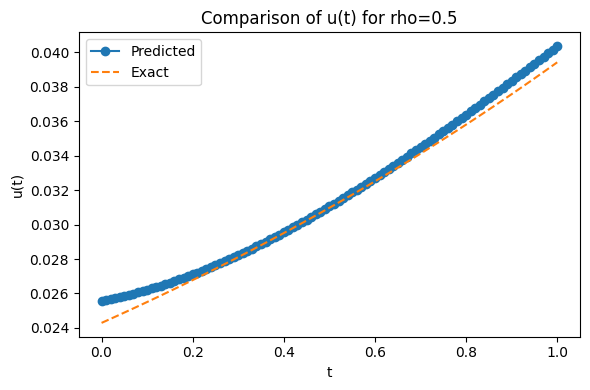

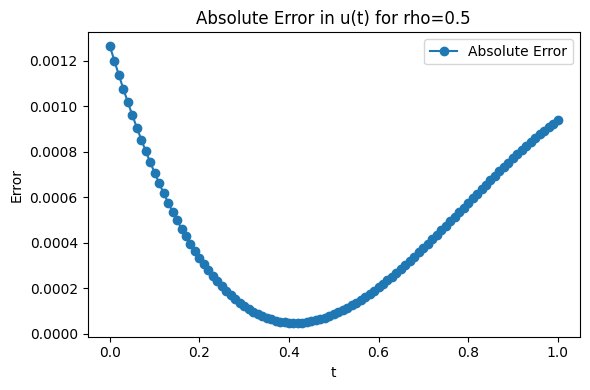

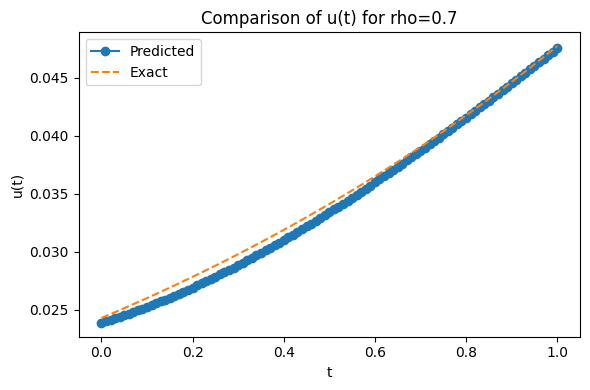

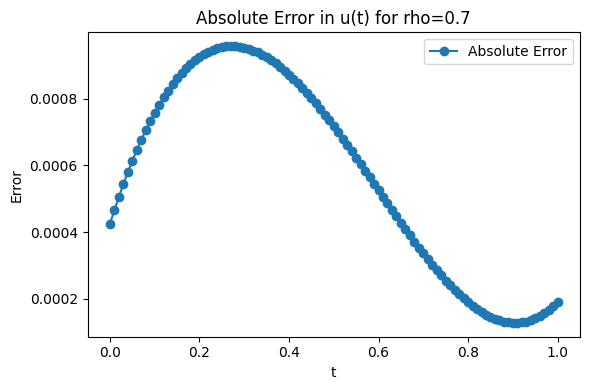

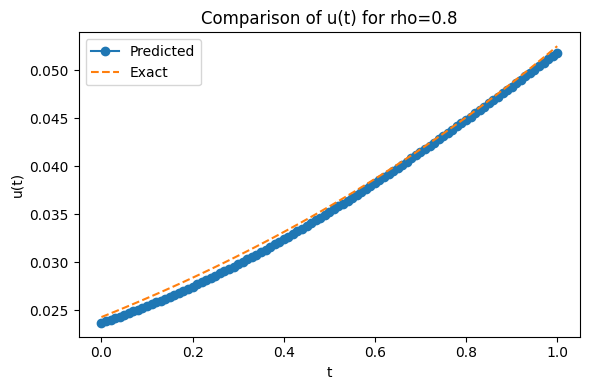

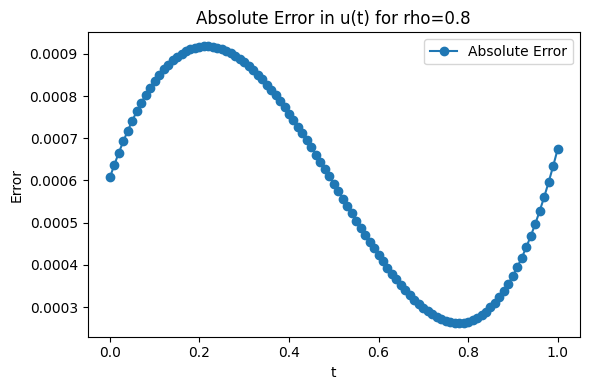

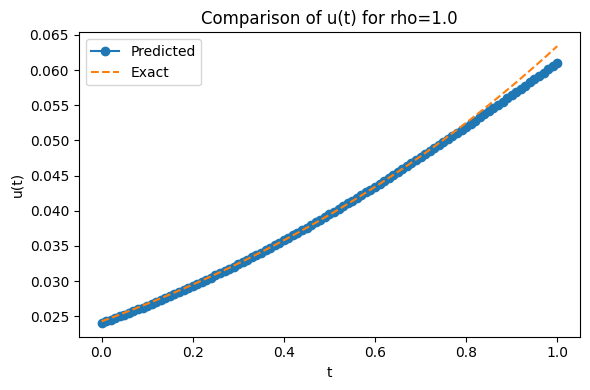

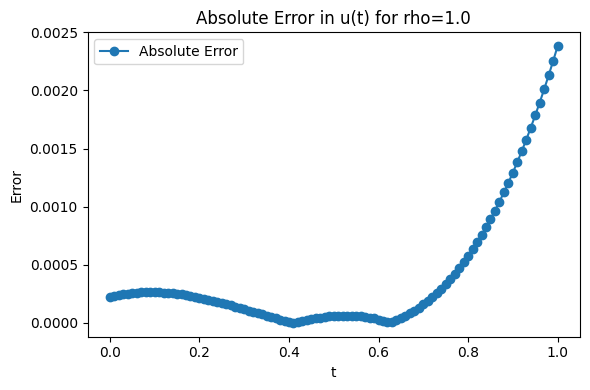

In [14]:
# %%
# Visualization for each rho value using line plots (since data is 1D in time).
for rho in rho_values:
    # Get test points for the current rho.
    x_test, t_test, _ = dataset.get_test_points(rho)
    rho_test = torch.full_like(x_test, rho).to(device)

    # Compute the analytical solution.
    u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101, 1)

    # Model predictions.
    with torch.no_grad():
        pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(101, 1)

    # Absolute error.
    abs_error = np.abs(u_analytical - pred)
    
    # Extract time values for plotting (1D array of shape (101,)).
    t_vals = t_test.cpu().detach().numpy().flatten()

    # Plot the predicted and exact solutions.
    plt.figure(figsize=(6, 4))
    plt.plot(t_vals, pred, label='Predicted', marker='o')
    plt.plot(t_vals, u_analytical, label='Exact', linestyle='--')
    plt.xlabel('t')
    plt.ylabel('u(t)')
    plt.title(f'Comparison of u(t) for rho={rho}')
    plt.legend()
    plt.tight_layout()
    # Updated file name for logistic ODE.
    plot_path = images_dir / f"1d_logistic_ode_fls_comparison_rho-{rho}.png"
    plt.savefig(plot_path)
    plt.show()

    # Plot the absolute error.
    plt.figure(figsize=(6, 4))
    plt.plot(t_vals, abs_error, label='Absolute Error', marker='o')
    plt.xlabel('t')
    plt.ylabel('Error')
    plt.title(f'Absolute Error in u(t) for rho={rho}')
    plt.legend()
    plt.tight_layout()
    plot_path = images_dir / f"1d_logistic_ode_fls_error_rho-{rho}.png"
    plt.savefig(plot_path)
    plt.show()